<a href="https://colab.research.google.com/github/Vedant2100/w26/blob/main/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q1. Setup andf MNIST models with diff k and p

 Normalization using train data mean and train data standard dev to both training and test data.

In [1]:
from datasets import load_dataset
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

dataset = load_dataset("cifar10")

def format_data(split, mean=None, std=None):
    images = np.array([np.array(img).flatten() for img in split["img"]])
    if mean is None or std is None:
        mean = np.mean(images, axis=0)
        std = np.std(images, axis=0)
    std_copy = std.copy()
    std_copy[std_copy == 0] = 1.0
    X = (images - mean) / std_copy
    y = np.array(split["label"])
    return X, y, mean, std

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [3]:
X_train, y_train, train_mean, train_std = format_data(dataset["train"])
X_test, y_test, _, _ = format_data(dataset["test"], train_mean, train_std)

In [ ]:
np.random.seed(0)
idxs = []
for c in range(10):
    class_idxs = np.where(y_train == c)[0]
    chosen = np.random.choice(class_idxs, size=1000, replace=True)
    idxs.append(chosen)
idxs = np.concatenate(idxs)
np.random.shuffle(idxs)
X_train = X_train[idxs]
y_train = y_train[idxs]

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class shallowNN(nn.Module):
    def __init__(self, k = 1, p = 0.1):
        super(shallowNN, self).__init__()
        self.fc1 = nn.Linear(3072, k) # CIFAR-10 images are 32x32x3 = 3072 pixels
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc1.bias)
        self.dropout = nn.Dropout(1-p) # keep probabilities are provided
        self.fc2 = nn.Linear(k, 10)
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc2.bias)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = shallowNN()

In [ ]:
import matplotlib.pyplot as plt
import tqdm


def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs = 80, lr = 0.001):
    model = shallowNN(k=k, p=p)
    model.apply(init_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    train_acc = {}
    test_acc = {}
    loss_hist = {}
    for epoch in tqdm.tqdm(range(epochs)):
        model.train()
        inputs = torch.tensor(X_train, dtype=torch.float32)
        labels = torch.tensor(y_train, dtype=torch.long)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, labels)
        loss_hist[(k, p, epoch)] = loss.item()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            model.eval()
            train_acc[(k, p, epoch)] = (model(inputs).argmax(dim=1) == labels).float().mean().item()
            test_outputs = model(torch.tensor(X_test, dtype=torch.float32))
            test_acc[(k, p, epoch)] = (test_outputs.argmax(dim=1) == torch.tensor(y_test, dtype=torch.long)).float().mean().item()
            model.train()
    del model
    return train_acc, test_acc, loss_hist

# Q2

## Q2.1 No dropout (p = 1.0 and dropout probability = 0.0)
With p = 1.0, as k (the number of units )increases, the training accuracy and test accuracy both improve up until k = 15 , where it has the best results, and then dropping when we get to k = 35. At no k in the current set, the training accuracy has become 100% but I tried increasing the learning rate as well as the no of epochs, and with lr = 0.01 and 500 epochs, k = 35 achieved 100% training accuracy and k = 15 very close by at 99.96%.

### LR = 0.001 (default)

100%|██████████| 80/80 [00:04<00:00, 16.44it/s]


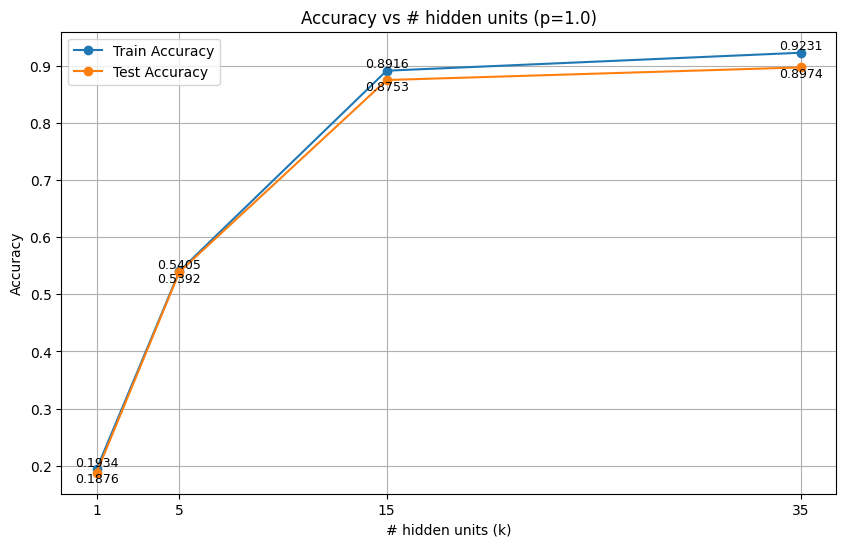

In [ ]:
torch.manual_seed(0)
kvals = [1, 5, 15, 35]
pvals = [1.0]
lr = 0.001
epochs = 80
for p in pvals:
    overall_train_acc = {}
    overall_test_acc = {}
    for k in kvals:
         train_acc, test_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr)
         overall_train_acc.update(train_acc)
         overall_test_acc.update(test_acc)
    plt.figure(figsize=(10, 6))
    plt.xticks(kvals)
    plt.plot(kvals, [overall_train_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Train Accuracy')
    plt.plot(kvals, [overall_test_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Test Accuracy')
    plt.xlabel('# hidden units (k)')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs # hidden units (p={p})')
    plt.legend()
    plt.grid()
    train_values = [overall_train_acc[(kv, p, epochs-1)] for kv in kvals]
    test_values = [overall_test_acc[(kv, p, epochs-1)] for kv in kvals]
    for i, kv in enumerate(kvals):
        plt.text(kv, train_values[i], f'{train_values[i]:.4f}', ha='center', va='bottom', fontsize=9)
        plt.text(kv, test_values[i], f'{test_values[i]:.4f}', ha='center', va='top', fontsize=9)
    plt.show()


### LR = 0.01

100%|██████████| 80/80 [00:05<00:00, 14.29it/s]


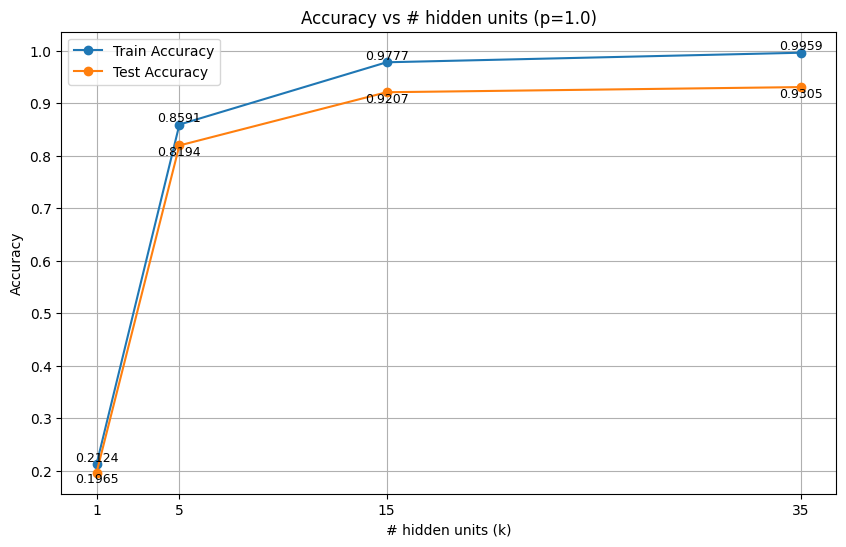

In [ ]:
torch.manual_seed(0)
kvals = [1, 5, 15, 35]
pvals = [1.0]
epochs = 80
lr = 0.01
for p in pvals:
    overall_train_acc = {}
    overall_test_acc = {}
    for k in kvals:
         train_acc, test_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr)
         overall_train_acc.update(train_acc)
         overall_test_acc.update(test_acc)
    plt.figure(figsize=(10, 6))
    plt.xticks(kvals)
    plt.plot(kvals, [overall_train_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Train Accuracy')
    plt.plot(kvals, [overall_test_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Test Accuracy')
    plt.xlabel('# hidden units (k)')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs # hidden units (p={p})')
    plt.legend()
    plt.grid()
    train_values = [overall_train_acc[(kv, p, epochs-1)] for kv in kvals]
    test_values = [overall_test_acc[(kv, p, epochs-1)] for kv in kvals]
    for i, kv in enumerate(kvals):
        plt.text(kv, train_values[i], f'{train_values[i]:.4f}', ha='center', va='bottom', fontsize=9)
        plt.text(kv, test_values[i], f'{test_values[i]:.4f}', ha='center', va='top', fontsize=9)
    plt.show()


100%|██████████| 500/500 [00:37<00:00, 13.36it/s]


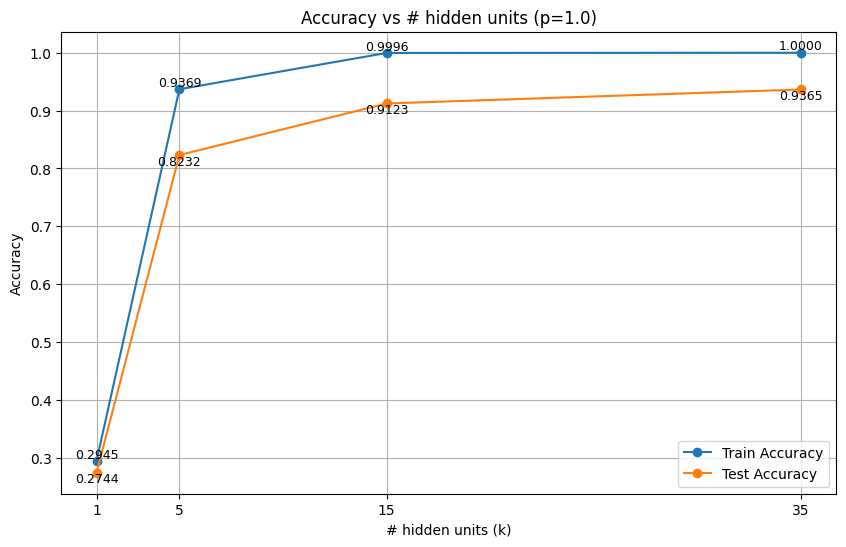

In [ ]:
torch.manual_seed(0)
kvals = [1, 5, 15, 35]
pvals = [1.0]
epochs = 500
lr = 0.01
for p in pvals:
    overall_train_acc = {}
    overall_test_acc = {}
    for k in kvals:
         train_acc, test_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr)
         overall_train_acc.update(train_acc)
         overall_test_acc.update(test_acc)
    plt.figure(figsize=(10, 6))
    plt.xticks(kvals)
    plt.plot(kvals, [overall_train_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Train Accuracy')
    plt.plot(kvals, [overall_test_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Test Accuracy')
    plt.xlabel('# hidden units (k)')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs # hidden units (p={p})')
    plt.legend()
    plt.grid()
    train_values = [overall_train_acc[(kv, p, epochs-1)] for kv in kvals]
    test_values = [overall_test_acc[(kv, p, epochs-1)] for kv in kvals]
    for i, kv in enumerate(kvals):
        plt.text(kv, train_values[i], f'{train_values[i]:.4f}', ha='center', va='bottom', fontsize=9)
        plt.text(kv, test_values[i], f'{test_values[i]:.4f}', ha='center', va='top', fontsize=9)
    plt.show()


## Q2.2

1. Generally the training accuracy has increased with increasing p i.e. (less dropout) which makes sense as the less neurons are randomly deactivated, the network's capacity to learning data is better. The lowest being with p = 0.1 case where in 90% neurons were randomly deactivated, reducing the model's learning capacity.

2. When p is smaller and thus dropout is higher its generally more difficult to optimize in terms of rate of change of accuracy w.r.t no of iterations (the slopes are slightly higher with higher p's)

100%|██████████| 80/80 [00:04<00:00, 16.49it/s]


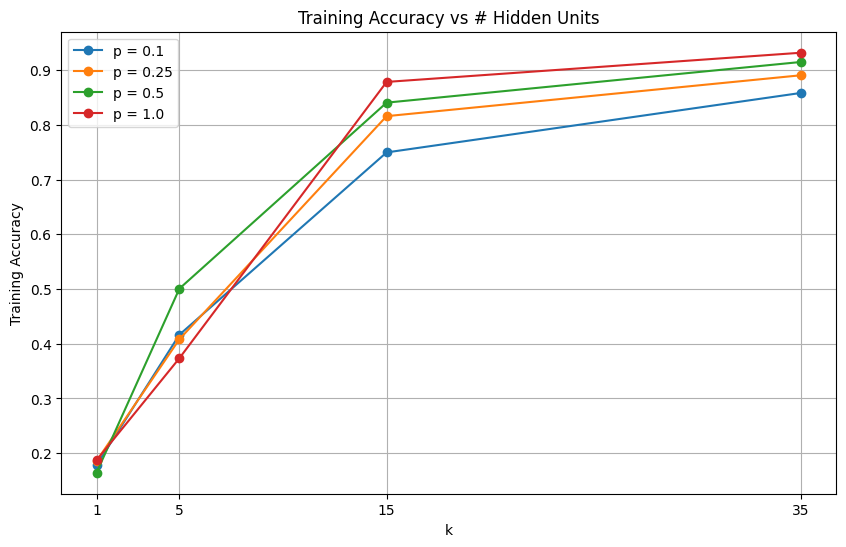

In [ ]:
kvals = [1, 5, 15, 35]
pvals = [0.1, 0.25, 0.5, 1.0]
epochs = 80
lr = 0.001
torch.manual_seed(0)
overall_train_acc = {}
overall_test_acc = {}
for p in pvals:
    for k in kvals:
         train_acc, test_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr)
         overall_train_acc.update(train_acc)
         overall_test_acc.update(test_acc)
plt.figure(figsize=(10, 6))
for p in pvals:
    plt.plot(kvals, [overall_train_acc[(k, p, epochs-1)] for k in kvals], marker='o',label=f"p = {p}")
plt.xticks(kvals)
plt.xlabel('k')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs # Hidden Units')
plt.legend()
plt.grid()
plt.show()


In [ ]:
for p in pvals:
    total_avg_slope = 0
    for k in kvals:
        acc_history = [overall_train_acc[(k, p, epoch)] for epoch in range(epochs)]
        total_delta_acc = acc_history[-1] - acc_history[0]
        total_delta_iter = epochs - 1
        total_avg_slope += (total_delta_acc / total_delta_iter)
    avg_slope_over_p = total_avg_slope / len(kvals)
    print(f"Average Convergence Slope for p={p}: {avg_slope_over_p:.6f}")

Average Convergence Slope for p=0.1: 0.005560
Average Convergence Slope for p=0.25: 0.005855
Average Convergence Slope for p=0.5: 0.006299
Average Convergence Slope for p=1.0: 0.006168


## Q2.2

3. For all values of p, a training accuracy of 100% is never achieved for any k, in the current setting..I will try a higher learning rate and more epochs.

With lr = 0.01 and epochs = 500, I get 100% training accuracy at k = 35 for p = 1. But for others, some more epochs will probably be needed. A high number of epochs would be required for p= 0.1 as, and it might not even converge.

100%|██████████| 300/300 [00:17<00:00, 16.69it/s]


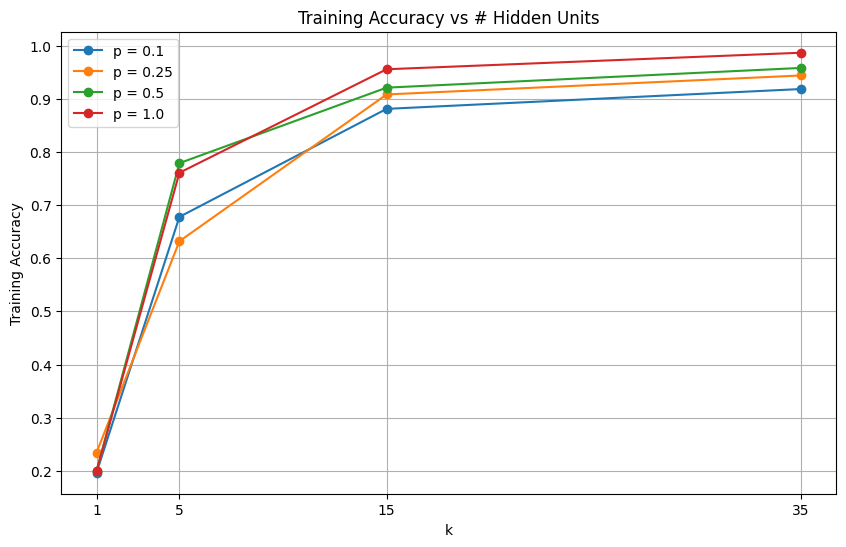

In [ ]:
kvals = [1, 5, 15, 35]
pvals = [0.1, 0.25, 0.5, 1.0]
epochs = 300
lr = 0.001
torch.manual_seed(0)
overall_train_acc = {}
overall_test_acc = {}
for p in pvals:
    for k in kvals:
         train_acc, test_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr)
         overall_train_acc.update(train_acc)
         overall_test_acc.update(test_acc)

plt.figure(figsize=(10, 6))

for p in pvals:
    plt.plot(kvals, [overall_train_acc[(k, p, epochs-1)] for k in kvals], marker='o',label=f"p = {p}")
plt.xticks(kvals)
plt.xlabel('k')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs # Hidden Units')
plt.annotate
plt.legend()
plt.grid()
plt.show()


In [ ]:
for p in pvals:
    for k in kvals:
        print(f"p={p}, k={k} | Final Train Acc: {overall_train_acc[(k, p, epochs-1)]:.4f}")

p=0.1, k=1 | Final Train Acc: 0.1965
p=0.1, k=5 | Final Train Acc: 0.6777
p=0.1, k=15 | Final Train Acc: 0.8809
p=0.1, k=35 | Final Train Acc: 0.9182
p=0.25, k=1 | Final Train Acc: 0.2341
p=0.25, k=5 | Final Train Acc: 0.6319
p=0.25, k=15 | Final Train Acc: 0.9080
p=0.25, k=35 | Final Train Acc: 0.9437
p=0.5, k=1 | Final Train Acc: 0.1993
p=0.5, k=5 | Final Train Acc: 0.7788
p=0.5, k=15 | Final Train Acc: 0.9208
p=0.5, k=35 | Final Train Acc: 0.9579
p=1.0, k=1 | Final Train Acc: 0.1996
p=1.0, k=5 | Final Train Acc: 0.7607
p=1.0, k=15 | Final Train Acc: 0.9554
p=1.0, k=35 | Final Train Acc: 0.9865


100%|██████████| 300/300 [00:17<00:00, 16.73it/s]


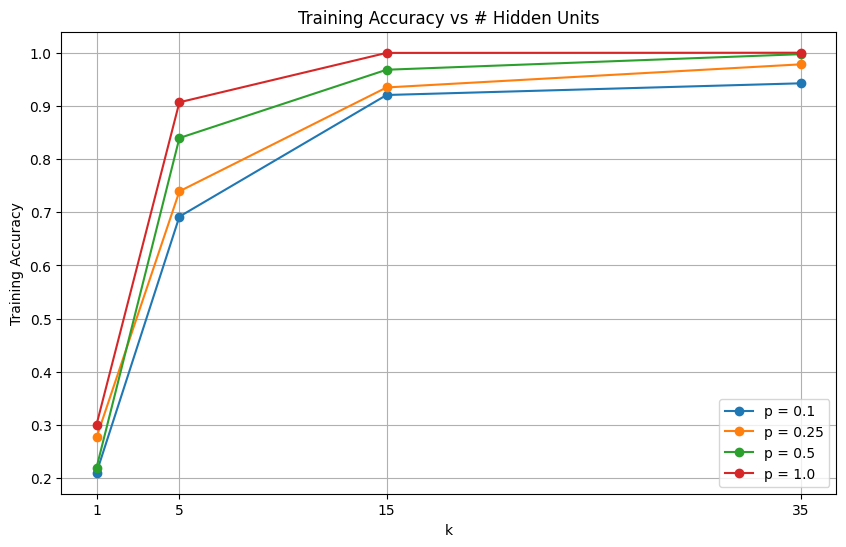

In [ ]:
kvals = [1, 5, 15, 35]
pvals = [0.1, 0.25, 0.5, 1.0]
epochs = 300
lr = 0.01
torch.manual_seed(0)
overall_train_acc = {}
overall_test_acc = {}
for p in pvals:
    for k in kvals:
         train_acc, test_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr)
         overall_train_acc.update(train_acc)
         overall_test_acc.update(test_acc)

plt.figure(figsize=(10, 6))

for p in pvals:
    plt.plot(kvals, [overall_train_acc[(k, p, epochs-1)] for k in kvals], marker='o',label=f"p = {p}")
plt.xticks(kvals)
plt.xlabel('k')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs # Hidden Units')
plt.annotate
plt.legend()
plt.grid()
plt.show()


In [ ]:
for p in pvals:
    for k in kvals:
        print(f"p={p}, k={k} | Final Train Acc: {overall_train_acc[(k, p, epochs-1)]:.4f}")

p=0.1, k=1 | Final Train Acc: 0.2102
p=0.1, k=5 | Final Train Acc: 0.6918
p=0.1, k=15 | Final Train Acc: 0.9205
p=0.1, k=35 | Final Train Acc: 0.9425
p=0.25, k=1 | Final Train Acc: 0.2765
p=0.25, k=5 | Final Train Acc: 0.7394
p=0.25, k=15 | Final Train Acc: 0.9347
p=0.25, k=35 | Final Train Acc: 0.9782
p=0.5, k=1 | Final Train Acc: 0.2196
p=0.5, k=5 | Final Train Acc: 0.8396
p=0.5, k=15 | Final Train Acc: 0.9680
p=0.5, k=35 | Final Train Acc: 0.9973
p=1.0, k=1 | Final Train Acc: 0.3005
p=1.0, k=5 | Final Train Acc: 0.9068
p=1.0, k=15 | Final Train Acc: 0.9997
p=1.0, k=35 | Final Train Acc: 1.0000


## Q2.3

1. Generally lower the p, the test accuracy is lower,  except p = 1.0 (no dropout) where at k = 5 it does worse despite having higher p. It could be that a model complexity of that is needed to fit the data well and higher dropout in other cases is causing underfitting. So , generally dropout is not helping for test accuracy

2. For k = 35, and p = 1.0, i get highest test accuracy of 0.90 (i.e. no dropout case)

100%|██████████| 80/80 [00:05<00:00, 13.96it/s]


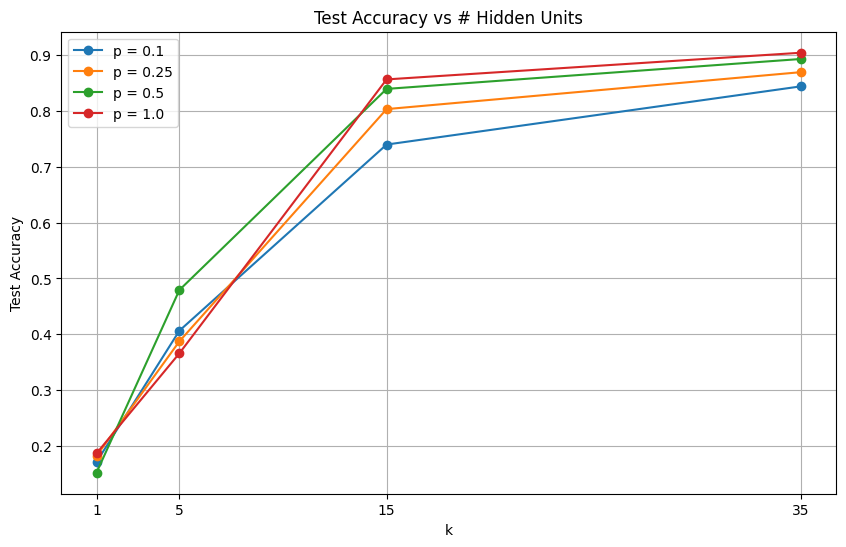

In [ ]:
kvals = [1, 5, 15, 35]
pvals = [0.1, 0.25, 0.5, 1.0]
epochs = 80
lr = 0.001
torch.manual_seed(0)
overall_train_acc = {}
overall_test_acc = {}
for p in pvals:
    for k in kvals:
         train_acc, test_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr)
         overall_train_acc.update(train_acc)
         overall_test_acc.update(test_acc)

plt.figure(figsize=(10, 6))

for p in pvals:
    plt.plot(kvals, [overall_test_acc[(k, p, epochs-1)] for k in kvals], marker='o',label=f"p = {p}")
plt.xticks(kvals)
plt.xlabel('k')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs # Hidden Units')
plt.legend()
plt.grid()
plt.show()


In [ ]:
for p in pvals:
    for k in kvals:
        print(f"p={p}, k={k} | Final Test Acc: {overall_test_acc[(k, p, epochs-1)]:.4f}")

p=0.1, k=1 | Final Train Acc: 0.1712
p=0.1, k=5 | Final Train Acc: 0.4064
p=0.1, k=15 | Final Train Acc: 0.7398
p=0.1, k=35 | Final Train Acc: 0.8441
p=0.25, k=1 | Final Train Acc: 0.1821
p=0.25, k=5 | Final Train Acc: 0.3873
p=0.25, k=15 | Final Train Acc: 0.8033
p=0.25, k=35 | Final Train Acc: 0.8695
p=0.5, k=1 | Final Train Acc: 0.1520
p=0.5, k=5 | Final Train Acc: 0.4793
p=0.5, k=15 | Final Train Acc: 0.8395
p=0.5, k=35 | Final Train Acc: 0.8931
p=1.0, k=1 | Final Train Acc: 0.1866
p=1.0, k=5 | Final Train Acc: 0.3659
p=1.0, k=15 | Final Train Acc: 0.8565
p=1.0, k=35 | Final Train Acc: 0.9043


# Q3

In [ ]:
np.random.seed(0)
possible_labels = list(range(0, 10))
flipped_example_index = np.random.choice(range(len(X_train)), size=4500, replace=False)
for i in flipped_example_index:
    original_label = y_train[i]
    other_labels = [l for l in possible_labels if l != original_label]
    y_train[i] = np.random.choice(other_labels, replace = True)

print(f"No of y_train flipped: {len(flipped_example_index)}")

No of y_train flipped: 4500


## Q3.1 No dropout p = 1.0
Even this time, as k increase the training accuracy improves. But, becuase the data is noisy, the training accuracy has dropped a lot. Because, with wrong labels, its penalising the model even when its right. It is generalizing well, according to the test accuracies and the low training accuracy being attributtable to the nosiy training labels. At no k, within 80 epochs (or even higher lr and 500 epochs), does the training accuracy becomes 100%.

100%|██████████| 80/80 [00:05<00:00, 14.03it/s]


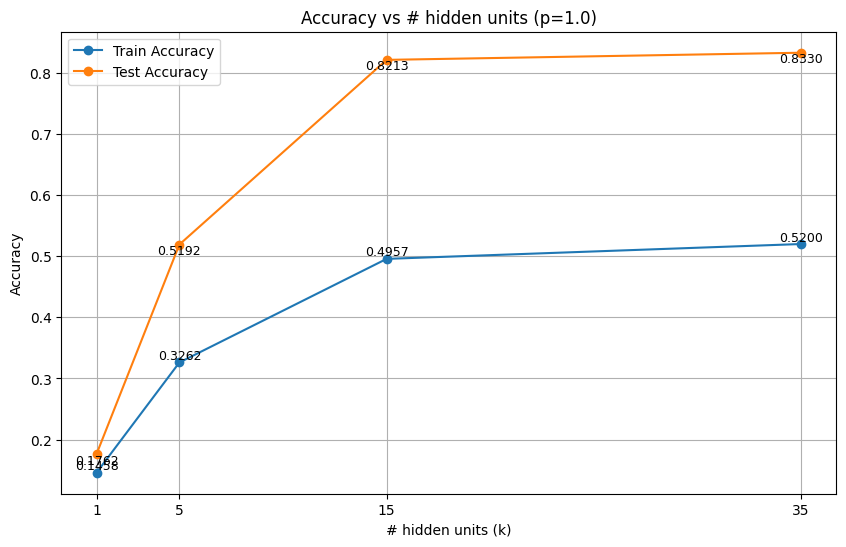

In [ ]:
torch.manual_seed(0)
kvals = [1, 5, 15, 35]
pvals = [1.0]
lr = 0.001
epochs = 80
for p in pvals:
    overall_train_acc = {}
    overall_test_acc = {}
    for k in kvals:
         train_acc, test_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr)
         overall_train_acc.update(train_acc)
         overall_test_acc.update(test_acc)
    plt.figure(figsize=(10, 6))
    plt.xticks(kvals)
    plt.plot(kvals, [overall_train_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Train Accuracy')
    plt.plot(kvals, [overall_test_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Test Accuracy')
    plt.xlabel('# hidden units (k)')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs # hidden units (p={p})')
    plt.legend()
    plt.grid()
    train_values = [overall_train_acc[(kv, p, epochs-1)] for kv in kvals]
    test_values = [overall_test_acc[(kv, p, epochs-1)] for kv in kvals]
    for i, kv in enumerate(kvals):
        plt.text(kv, train_values[i], f'{train_values[i]:.4f}', ha='center', va='bottom', fontsize=9)
        plt.text(kv, test_values[i], f'{test_values[i]:.4f}', ha='center', va='top', fontsize=9)
    plt.show()


100%|██████████| 500/500 [00:36<00:00, 13.56it/s]


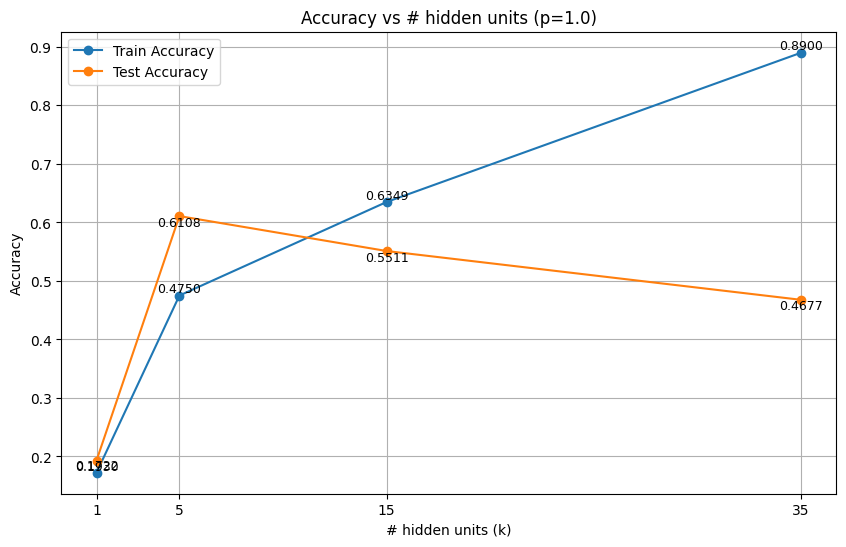

In [ ]:
torch.manual_seed(0)
kvals = [1, 5, 15, 35]
pvals = [1.0]
lr = 0.01
epochs = 500
for p in pvals:
    overall_train_acc = {}
    overall_test_acc = {}
    for k in kvals:
         train_acc, test_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr)
         overall_train_acc.update(train_acc)
         overall_test_acc.update(test_acc)
    plt.figure(figsize=(10, 6))
    plt.xticks(kvals)
    plt.plot(kvals, [overall_train_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Train Accuracy')
    plt.plot(kvals, [overall_test_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Test Accuracy')
    plt.xlabel('# hidden units (k)')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs # hidden units (p={p})')
    plt.legend()
    plt.grid()
    train_values = [overall_train_acc[(kv, p, epochs-1)] for kv in kvals]
    test_values = [overall_test_acc[(kv, p, epochs-1)] for kv in kvals]
    for i, kv in enumerate(kvals):
        plt.text(kv, train_values[i], f'{train_values[i]:.4f}', ha='center', va='bottom', fontsize=9)
        plt.text(kv, test_values[i], f'{test_values[i]:.4f}', ha='center', va='top', fontsize=9)
    plt.show()


The Signal: The 5,500 correct examples all agree on what a "3" looks like (consistent curves, open middle).
The Noise: The 4,500 wrong examples are random. Some "3"s are labeled as "1", some as "8", some as "0". The gradients from the 5,500 correct examples all push the weights in the same direction, while the gradients from the noisy labels push the weights in random, conflicting directions. Over many batches, the random noise cancels itself out, but the consistent signal accumulates.

## Q3.2
1. Similarly as Q2 generally the training accuracy has increased with increasing p i.e. (less dropout) except some cases at k = 1 nd k = 5.

2. When p is smaller and thus dropout is higher its generally more difficult to optimize in terms of rate of change of accuracy w.r.t no of iterations (the slopes are slightly higher with higher p's)

100%|██████████| 80/80 [00:05<00:00, 14.29it/s]


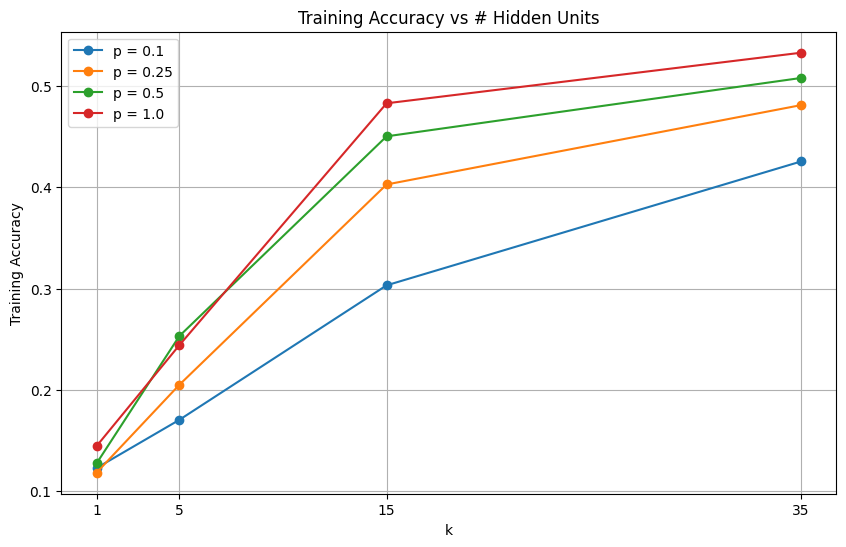

In [ ]:
kvals = [1, 5, 15, 35]
pvals = [0.1, 0.25, 0.5, 1.0]
epochs = 80
lr = 0.001
torch.manual_seed(0)
overall_train_acc = {}
overall_test_acc = {}
for p in pvals:
    for k in kvals:
         train_acc, test_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr)
         overall_train_acc.update(train_acc)
         overall_test_acc.update(test_acc)
plt.figure(figsize=(10, 6))
for p in pvals:
    plt.plot(kvals, [overall_train_acc[(k, p, epochs-1)] for k in kvals], marker='o',label=f"p = {p}")
plt.xticks(kvals)
plt.xlabel('k')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs # Hidden Units')
plt.legend()
plt.grid()
plt.show()

In [ ]:
for p in pvals:
    total_avg_slope = 0
    for k in kvals:
        acc_history = [overall_train_acc[(k, p, epoch)] for epoch in range(epochs)]
        total_delta_acc = acc_history[-1] - acc_history[0]
        total_delta_iter = epochs - 1
        total_avg_slope += (total_delta_acc / total_delta_iter)
    avg_slope_over_p = total_avg_slope / len(kvals)
    print(f"Average Convergence Slope for p={p}: {avg_slope_over_p:.6f}")

Average Convergence Slope for p=0.1: 0.001876
Average Convergence Slope for p=0.25: 0.002525
Average Convergence Slope for p=0.5: 0.002868
Average Convergence Slope for p=1.0: 0.003151


## Q3.2
3. For no value of k among each p, does the training accuracy become 100%. Even if we train for 500 epochs, it would not become 100% because of the incorrect labels due to the noise.

## Q3.3

1. Generally higher the p, the test accuracy is higher,  except p = 0.5 where at k = 5 it does better despite having lower p than p = 1.0 (i.e. despite having higher dropout). So, dropout is not helping with testv accuracy, generally.

2. For k = 35, and p = 0.5, i get highest test accuracy of 0.83.

100%|██████████| 80/80 [00:05<00:00, 14.83it/s]


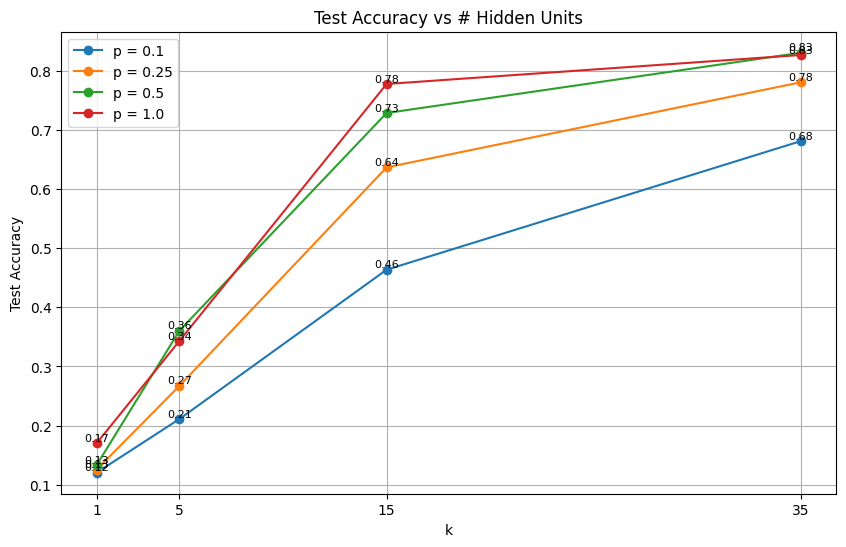

In [ ]:
kvals = [1, 5, 15, 35]
pvals = [0.1, 0.25, 0.5, 1.0]
epochs = 80
lr = 0.001
torch.manual_seed(0)
overall_train_acc = {}
overall_test_acc = {}
for p in pvals:
    for k in kvals:
         train_acc, test_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr)
         overall_train_acc.update(train_acc)
         overall_test_acc.update(test_acc)
plt.figure(figsize=(10, 6))
for p in pvals:
    y_vals = [overall_test_acc[(kv, p, epochs-1)] for kv in kvals]
    plt.plot(kvals, y_vals, marker='o', label=f"p = {p}")
    for i, kv in enumerate(kvals):
        plt.text(kv, y_vals[i], f'{y_vals[i]:.2f}', fontsize=8, ha='center', va='bottom')
plt.xticks(kvals)
plt.xlabel('k')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs # Hidden Units')
plt.legend()
plt.grid()
plt.show()


In [ ]:
for p in pvals:
    for k in kvals:
        print(f"p={p}, k={k} | Final Test Acc: {overall_test_acc[(k, p, epochs-1)]:.4f}")

p=0.1, k=1 | Final Test Acc: 0.1203
p=0.1, k=5 | Final Test Acc: 0.2111
p=0.1, k=15 | Final Test Acc: 0.4637
p=0.1, k=35 | Final Test Acc: 0.6814
p=0.25, k=1 | Final Test Acc: 0.1253
p=0.25, k=5 | Final Test Acc: 0.2672
p=0.25, k=15 | Final Test Acc: 0.6368
p=0.25, k=35 | Final Test Acc: 0.7809
p=0.5, k=1 | Final Test Acc: 0.1329
p=0.5, k=5 | Final Test Acc: 0.3605
p=0.5, k=15 | Final Test Acc: 0.7288
p=0.5, k=35 | Final Test Acc: 0.8308
p=1.0, k=1 | Final Test Acc: 0.1699
p=1.0, k=5 | Final Test Acc: 0.3432
p=1.0, k=15 | Final Test Acc: 0.7779
p=1.0, k=35 | Final Test Acc: 0.8270


# Q4

In Q2, the training and test accuracy were closer and moving together. Because the labels are correct, the network tries to match them perfectly.

But in Q3, when the data is only 55% correctly labeled, the training accuracy reaches max 52% while the test accuracy is much higher.

Due to the noise in 45% of the data in Q3,an explanation of the gap could be that a model that predicts the correct digit will be told it is wrong 45% of the time by the training set.
which forces the model to ignore individual labels and look for an underlying signal across many images.

In the current setup (k=1 to 35), dropout is not helpful in either Q2 or Q3, but for different reasons:

Q2: More dropout is harming model performance. Since the data is clean and the model is small (k=35),underfitting is observed because of the dropout.

Q3: Currently with k = 35, I feel dropout is redundant with noisy data, as the model isnt big enough to try and memorize the noise. At higher values of k, as the model would try to memorize the training data, we could add dropout and it would help out in avoiding the resulting overfitting.